<a href="https://colab.research.google.com/github/CelikAbdullah/deep-learning-notebooks/blob/main/Deep%20Reinforcement%20Learning%20(TF)/Policy%20Based/VPG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
from itertools import count
import numpy as np
import gym
import time

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <


# Policy Network

This is the fully connected policy network, we will use in the VPG algorithm to learn the policy. It is the same network as in the REINFORCE algorithm:

In [ ]:
class PolicyNetwork(tf.keras.Model):
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.input_dim = input_dim
    self.output_dim = output_dim
    self.model = self.get_model()

  def get_model(self):
    inputs = tf.keras.Input(shape=(None, self.input_dim))
    x = tf.keras.layers.Dense(units=128, activation="relu")(inputs)
    x = tf.keras.layers.Dense(units=64, activation="relu")(x)
    outputs = tf.keras.layers.Dense(units=self.output_dim)(x)
    return tf.keras.Model(inputs=inputs, outputs=outputs)

  def _format(self, state):
    x = state
    if not isinstance(x, tf.Tensor):
      x = tf.convert_to_tensor(x)
    if tf.rank(x) == 1:
      x = tf.expand_dims(x, 0)

    return x

  def call(self, state):
    x = self._format(state)
    output = self.model(x)

    return output

  def full_pass(self, state):
    logits = self(state)
    # Create a Categorical distribution
    dist = tfp.distributions.Categorical(logits=logits)
    # sample an action from the Categorical distribution
    action = dist.sample()
    # compute the log probabilites of each action
    logpa = dist.log_prob(action)
    logpa = tf.expand_dims(logpa, axis=-1)

    # compute the entropy of the policy
    # high entropy when action probabilities are similar to each other
    # low entropy when 1 action has a very high probability & all other actions have low probability
    # the entropy will be used in the loss function
    # entropy = dist.entropy().unsqueeze(-1)
    entropy = dist.entropy()
    entropy = tf.expand_dims(entropy, axis=-1)

    return action.numpy().item(), logpa, entropy

  def select_action(self, state):
    # forward pass
    logits = self(state)
    # get a probability distribution
    dist = tfp.distributions.Categorical(logits=logits)
    # sample an action from the probability distribution
    action = dist.sample()

    return action.numpy().item()

  def select_greedy_action(self, state):
    # forward pass
    logits = self(state)
    # return index of action with the highest probability
    return np.argmax(logits)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Value Network

This is the fully connected value network, we will use in the VPG algorithm to learn the state-value function:

In [ ]:
class ValueNetwork(tf.keras.Model):
  def __init__(self, input_dim):
    super().__init__()
    self.input_dim = input_dim
    self.model = self.get_model()

  def get_model(self):
    inputs = tf.keras.Input(shape=(None, self.input_dim))
    x = tf.keras.layers.Dense(units=256, activation="relu")(inputs)
    x = tf.keras.layers.Dense(units=128, activation="relu")(x)
    outputs = tf.keras.layers.Dense(units=1)(x)
    return tf.keras.Model(inputs=inputs, outputs=outputs)

  def _format(self, state):
    x = state
    if not isinstance(x, tf.Tensor):
      x = tf.convert_to_tensor(x)
    if tf.rank(x) == 1:
      x = tf.expand_dims(x, 0)

    return x

  def call(self, state):
    x = self._format(state)
    output = self.model(x)

    return output

# VPG

In the vanilla policy gradient (VPG) algorithm, we use the actual returns, such as in REINFORCE, and subtract the learned value function (baseline) to reduce the variance of the gradient.
Basically, we use the advantage function as the policy score.

Here, a definition of the true action-advantage function:

$a_\pi(s, a) = q_\pi(s,a) - v_\pi(s)$

We are able to approximate that function via the following:

$A(S_t, A_t) \approx R_t + \gamma R_{t+1} + ... + \gamma^{T-1}R_T - v_\pi(S_t)$

Since $G_t = R_t + \gamma R_{t+1} + ... + \gamma^{T-1}R_T$, we can also say:

$A(S_t, A_t) \approx G_t - v_\pi(S_t)$, whereas $G_t$ is the return from timestep $t$ to the last timestep $T$ and $v_\pi(S_t)$ is the estimated expected return from the state at timestep $t$.

The loss for the value function is the following:

$L_v(\phi) = \dfrac{1}{N} \sum_{n=0}^N [(G_t - V(S_t; \phi))^2]$

The loss for the policy is the following:

$L_\pi(\theta) = - \dfrac{1}{N} \sum_{n=0}^N [\underbrace{(G_t - V(S_t; \phi))}_\text{action-advantage fct} \underbrace{log\pi(A_t|S_t; \theta)}_\text{log probabilities of the actions}+ \beta \underbrace{ H(\pi(S_t; \theta))}_\text{entropy of the policy}]$

As you can notice, we encourage exploration by adding the entropy of the policy to the loss function. Recall that the evenly distributed actions result in a high entropy. That way, a policy with evenly distributed actions has a high entropy and therefore, it contributes to minimizing the loss.

As in REINFORCE, since we learn a stochastic policy, the exploration is on-policy. That is, exploration is taken care of by the policy itself because it is stochastic; it has randomness.

In [ ]:
class VPG():

  def __init__(self,
               env,
               policy_model,
               value_model,
               policy_optimizer,
               value_optimizer,
               policy_model_max_grad_norm,
               value_model_max_grad_norm,
               entropy_loss_weight,
               gamma,
               seed,
               max_episodes = 10000,
               max_minutes = 10,
               goal=475):


    # set the attributes
    self.env = env
    self.policy_model = policy_model
    self.value_model = value_model
    self.policy_optimizer = policy_optimizer
    self.value_optimizer = value_optimizer
    self.policy_model_max_grad_norm = policy_model_max_grad_norm
    self.value_model_max_grad_norm = value_model_max_grad_norm
    self.entropy_loss_weight = entropy_loss_weight
    self.gamma = gamma
    self.max_episodes = max_episodes
    self.max_minutes = max_minutes
    self.goal = goal
    self.seed = seed
    self.evaluation_scores = []
    self.mean_eval_scores = []

  def __interact(self, state):
    '''
    Interact with the environment.
    '''
    # pass the state through the policy network
    action, logpa, entropy = self.policy_model.full_pass(state)
    # perform the sampled action from the probability distribution in the environment
    new_state, reward, is_terminal, info = self.env.step(action)
    # check CartPole's built-in time limit
    is_truncated = 'TimeLimit.truncated' in info and info['TimeLimit.truncated']
    # save the log probability of the action
    self.logpas.append(logpa)
    # save the entropy of the policy
    self.entropies.append(entropy)
    # save the experienced reward after taking the selected action
    self.rewards.append(reward)
    # save the output of the model approximating the state-value fct
    self.values.append(self.value_model(state))

    return new_state, is_terminal, is_truncated

  def __compute_losses(self):
    T = len(self.rewards)
    discounts = np.logspace(0, T, num=T, base=self.gamma, endpoint=False)
    returns = np.array([np.sum(discounts[:T-t] * self.rewards[t:]) for t in range(T)])
    discounts = tf.convert_to_tensor(discounts[:-1], dtype="float32")
    discounts = tf.expand_dims(discounts, axis=1)
    returns = tf.convert_to_tensor(returns[:-1], dtype="float32")
    returns = tf.expand_dims(returns, axis=1)

    self.logpas = tf.concat(self.logpas, axis=0)
    self.entropies = tf.concat(self.entropies, axis=0)
    self.values = tf.concat(self.values, axis=0)

    value_error = returns - self.values

    loss = -tf.reduce_mean(discounts * tf.stop_gradient(value_error) * self.logpas)
    entropy_loss = -tf.reduce_mean(self.entropies)
    policy_loss = loss + self.entropy_loss_weight * entropy_loss

    value_loss = tf.reduce_mean(tf.square(value_error) * 0.5)

    return policy_loss, value_loss

  def __optimize(self, policy_loss, value_loss, policy_tape, value_tape):
    '''
    Optimize the models.
    '''
    # compute the gradients of the policy loss with respect to the trainable variables
    policy_grads = policy_tape.gradient(policy_loss, self.policy_model.trainable_variables)
    # clip the gradients
    clipped_policy_grads, _ = tf.clip_by_global_norm(policy_grads, self.policy_model_max_grad_norm)
    # update the weights
    self.policy_optimizer.apply_gradients(zip(clipped_policy_grads, self.policy_model.trainable_variables))


    # compute the gradients of the value loss with respect to the trainable variables
    value_grads = value_tape.gradient(value_loss, self.value_model.trainable_variables)
    # clip the gradients
    clipped_value_grads, _ = tf.clip_by_global_norm(value_grads, self.value_model_max_grad_norm)
    # update the weights
    self.value_optimizer.apply_gradients(zip(clipped_value_grads, self.value_model.trainable_variables))

  def __evaluate(self, episodes=1, greedy=True):
    ''' Evaluate the model. '''

    # keep track of the rewards
    rewards = []
    # for each episode (default: 1) do the following
    for _ in range(episodes):
      # get the initial state
      state = self.env.reset()
      # set is_terminal flag to False
      is_terminal = False
      # append a 0 to rewards list
      rewards.append(0)
      # for each timestep of the current episode, do the following
      for _ in count():
        if greedy:
          # select a greedy action according to the policy.
          action = self.policy_model.select_greedy_action(state)
        else:
          # sample an action from the distribution
          action = self.policy_model.select_action(state)

        # take the action in the environment
        state, reward, is_terminal, _ = self.env.step(action)
        # save the reward
        rewards[-1] += reward
        # finish when terminal state is reached
        if is_terminal:
          break

    # return the mean of the rewards to the caller
    return np.mean(rewards)

  def train(self):
    '''
    Train the agent.
    '''
    # get the starting time of the training phase
    training_start = time.time()
    # for each episode do the following
    for episode in range(1, self.max_episodes + 1):

      # get the initial state
      state = self.env.reset(seed=self.seed)
      # is_terminal flag to indicate whether an episode is finished
      is_terminal = False
      # list to hold the log probabilities of the actions
      self.logpas = []
      # list to hold the rewards
      self.rewards = []
      # list to hold the entropies
      self.entropies = []
      # list to hold the values
      self.values = []

      with tf.GradientTape() as policy_tape, tf.GradientTape() as value_tape:
        # we first collect a full trajectory
        for timestep in count():
          # interact with the environment

          state, is_terminal, is_truncated = self.__interact(state)
          # finish current episode if a terminal state is reached
          if is_terminal:
            break

        # handle a failure
        is_failure = is_terminal and not is_truncated
        #next_value = 0 if is_failure else value_model(state).detach().item()
        if is_failure:
          next_value = 0
        else:
          output = self.value_model(state, training=False)
          #output_detached = tf.stop_gradient(output)
          next_value = output.numpy().item()

        # append next_value to the rewards list
        self.rewards.append(next_value)
        # compute the loss
        policy_loss, value_loss = self.__compute_losses()



      # update the weights
      self.__optimize(policy_loss, value_loss, policy_tape, value_tape)

      # compute the evaluation score
      evaluation_score = self.__evaluate()
      # store the evaluation score
      self.evaluation_scores.append(evaluation_score)
      # compute the mean evaluation score
      mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
      # append mean evaluation score (will be used later for visualization)
      self.mean_eval_scores.append(mean_100_eval_score)
      print(f"Episode {episode}: Current mean evaluation score {mean_100_eval_score}") # printing for debugging purposes

      # calculate the elapsed wallclock time
      wallclock_elapsed = time.time() - training_start

      # flag indicating whether max minutes are reached or not
      reached_max_minutes = wallclock_elapsed >= self.max_minutes * 60
      # flag indicating whether max episodes are reached or not
      reached_max_episodes = episode >= self.max_episodes
      # flag indicating whether the mean reward goal is reached
      reached_goal_mean_reward = mean_100_eval_score >= self.goal

      # flag that decides whether is over or not
      training_is_over = reached_max_minutes or reached_max_episodes or reached_goal_mean_reward

      if training_is_over:
        if reached_max_minutes: print('Max minutes are reached')
        if reached_max_episodes: print('Max episodes are reached')
        if reached_goal_mean_reward: print('Goal mean reward is reached')
        break


    # compute final evaluation score
    final_evaluation_score = self.__evaluate(episodes=100)
    print(f"Final evaluation score: {final_evaluation_score}")

    self.env.close()
    del self.env

    return final_evaluation_score

# Train

In [ ]:
# define the weight for the entropy loss
entropy_loss_weight = 0.001
# define the our discount factor
gamma = 0.99
# define max minutes
max_minutes = 30
# define nr. of max episodes
max_episodes = 10000
# define mean reward value
goal = 500
# learning rate for the policy optimizer
p_lr = 0.0005
# learning rate for the value optimizer
v_lr = 0.0005

current_best_agent = None
current_best_eval_score = float('-inf')
seeds = (12, 34, 56, 78, 90)

In [ ]:
# we let five VPG agents train, the one with the best evaluation score will be selected as the best one
# in each iteration, a different seed is used for creating the environment
for seed in seeds:
  # create an instance of the environment
  env = gym.make("CartPole-v1")
  # obtain the number of variables used in each state and the number of actions
  state_space = env.observation_space.shape[0]
  action_space = env.action_space.n
  # build the policy network
  policy_model = PolicyNetwork(state_space, action_space)
  policy_model_max_grad_norm = 1
  policy_optimizer = tf.keras.optimizers.Adam(learning_rate=p_lr)
  # build the value network
  value_model = ValueNetwork(state_space)
  value_model_max_grad_norm = 1
  value_optimizer = tf.keras.optimizers.Adam(learning_rate=v_lr)

  # create the VPG agent
  vpg_agent = VPG(env,
                  policy_model,
                  value_model,
                  policy_optimizer,
                  value_optimizer,
                  policy_model_max_grad_norm,
                  value_model_max_grad_norm,
                  entropy_loss_weight,
                  gamma,
                  seed,
                  max_episodes,
                  max_minutes,
                  goal
                  )

  # let the VPG agent train
  final_evaluation_score = vpg_agent.train()

  # check if current agent performed better
  if final_evaluation_score > current_best_eval_score:
    current_best_eval_score = final_evaluation_score
    current_best_agent = vpg_agent

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode 1: Current mean evaluation score 10.0
Episode 2: Current mean evaluation score 16.5
Episode 3: Current mean evaluation score 18.666666666666668
Episode 4: Current mean evaluation score 16.5
Episode 5: Current mean evaluation score 15.2
Episode 6: Current mean evaluation score 14.333333333333334
Episode 7: Current mean evaluation score 13.714285714285714
Episode 8: Current mean evaluation score 13.25
Episode 9: Current mean evaluation score 12.88888888888889
Episode 10: Current mean evaluation score 12.6
Episode 11: Current mean evaluation score 12.363636363636363
Episode 12: Current mean evaluation score 12.166666666666666
Episode 13: Current mean evaluation score 12.0
Episode 14: Current mean evaluation score 11.857142857142858
Episode 15: Current mean evaluation score 11.733333333333333
Episode 16: Current mean evaluation score 11.625
Episode 17: Current mean evaluation score 11.529411764705882
Episode 18: Current mean evaluation score 11.444444444444445
Episode 19: Current m

# Saving the model

In [ ]:
vpg_agent.policy_model.save_weights("/content/drive/MyDrive/Tensorflow/VPG/VPG.ckpt")

# Visualize

Let's plot the mean of rewards our best agent has collected during the training process:

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


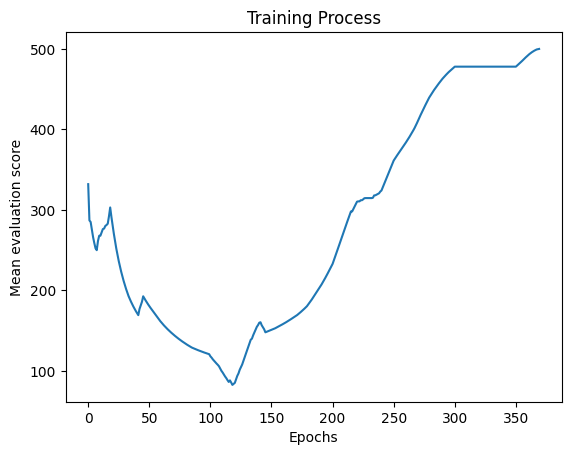

In [ ]:
import matplotlib.pyplot as plt

plt.plot(vpg_agent.mean_eval_scores)
plt.xlabel("Epochs")
plt.ylabel("Mean evaluation score")
plt.title("Training Process")
plt.show()

# Let our VPG agent play CartPole

In [ ]:
import os
import imageio
from PIL import Image as Im
import PIL.ImageDraw as ImageDraw
from IPython import display

In [ ]:
def create_gif(env, episodes):
  # list to keep track of frames
  frames = []

  for episode in range(0, episodes+1):
    # get the initial state
    state = env.reset()

    # for each timestep, do the following
    for t in range(500):
      # select an action from the probability distribution
      action = vpg_agent.policy_model.select_greedy_action(state)

      # get the frame & store it
      frame = env.render(mode='rgb_array')

      # prepare the frame
      im = Im.fromarray(frame)
      drawer = ImageDraw.Draw(im)
      if np.mean(im) < 128:
        text_color = (255,255,255)
      else:
        text_color = (0,0,0)
        drawer.text((im.size[0]/20,im.size[1]/18), f'Episode: {episode}', fill=text_color)
        drawer.text((im.size[0]/20,im.size[1]/8), f'Timestep: {t+1}', fill=text_color)

      # store the frame
      frames.append(im)

      # take the action in the environment
      state, _, is_terminal, _ = env.step(action)

      # if we land at a terminal state, break
      if is_terminal:
        break

    # close the environment
    env.close()

    # create the gif
    imageio.mimwrite(os.path.join('/content/drive/MyDrive/Tensorflow/VPG/Gif/', 'VPG_agent.gif'), frames, duration=20)

In [ ]:
episodes = 5
env = gym.make('CartPole-v1')
create_gif(env, episodes)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


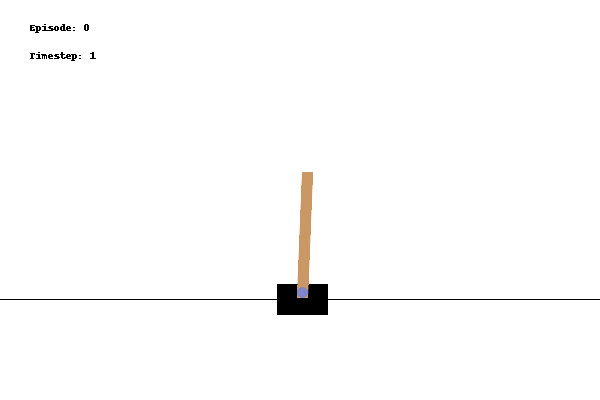

In [ ]:
from IPython import display
display.Image(open('/content/drive/MyDrive/Tensorflow/VPG/Gif/VPG_agent.gif','rb').read())